# Titanic Dataset Survivor Classification

### Importing libraries...

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import keras
from keras.layers import Input, Dense, BatchNormalization, Activation, Dropout
from keras import Model, regularizers

### Importing datasets...

In [3]:
root = Path.cwd()
data = root/'data'

In [4]:
train_data = pd.read_csv(data/"train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_data = pd.read_csv(data/"test.csv")
test_output = pd.read_csv(data/"test_real_outcomes.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
train_data.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

In [7]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
data=train_data.values

### Cleaning the dataset...

In [9]:
def name_feature(df):
    x = np.zeros((df.shape[0], 17))
    df["Name_title"] = df['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
    for i in range(df.shape[0]):
        if df["Name_title"][i] == 'Mr.':
            x[i][0]=1
        elif df["Name_title"][i] == 'Miss.':
            x[i][1]=1
        elif df["Name_title"][i] == 'Mrs.':
            x[i][2]=1
        elif df["Name_title"][i] == 'Master.':
            x[i][3]=1
        elif df["Name_title"][i] == 'Dr.':
            x[i][4]=1
        elif df["Name_title"][i] == 'Rev.':
            x[i][5]=1
        elif df["Name_title"][i] == 'Major.':
            x[i][6]=1
        elif df["Name_title"][i] == 'Mlle.':
            x[i][7]=1
        elif df["Name_title"][i] == 'Col.':
            x[i][8]=1
        elif df["Name_title"][i] == 'Jonkheer.':
            x[i][9]=1
        elif df["Name_title"][i] == 'Sir.':
            x[i][10]=1
        elif df["Name_title"][i] == 'Capt.':
            x[i][11]=1
        elif df["Name_title"][i] == 'Mme.':
            x[i][12]=1
        elif df["Name_title"][i] == 'Ms.':
            x[i][13]=1
        elif df["Name_title"][i] == 'the':
            x[i][14]=1
        elif df["Name_title"][i] == 'Lady.':
            x[i][15]=1
        elif df["Name_title"][i] == 'Don.':
            x[i][16]
    return x

In [10]:
def braces_in_names(df):
    a=np.zeros((df.shape[0],1))
    for i in range(df.shape[0]):
        if not df["Name"][i].replace(' ','').replace(',','').replace('.','').find('(')==-1:
            a[i]=1
        else:
            a[i]=0
    return a

In [11]:
def isNaN(string):
    return string!= string

In [12]:
def data_gen(data,df):
    a0=np.zeros((data.shape[0],2))
    for i in range(data.shape[0]):
        if data[i][3]=='male':
            a0[i][0]=1
        elif data[i][3]=='female':
            a0[i][1]=1
    
    for i in range(data.shape[0]):
        if np.isnan(data[i][4]):
            data[i][4]=train_data["Age"].median(axis=0)
            
    a1=np.zeros((data.shape[0],3))
    for i in range(data.shape[0]):
        if data[i][10]=='S':
            a1[i][0]=1
        elif data[i][10]=='C':
            a1[i][1]=1
        elif data[i][10]=='Q':
            a1[i][2]=1
        else:
            a1[i][0]=1
    
    
    a2=np.zeros((data.shape[0],8))
    b=np.zeros((data.shape[0],4))

    for i in range(data.shape[0]):
        if not isNaN(data[i][9]):
            z=0;q="";
            for j in data[i][9]:
                if j.isdigit():
                    q+=j
                elif j.isalpha():
                    if j=='A':
                        a2[i][0]=1
                    elif j=='B':
                        a2[i][1]=1
                    elif j=='C':
                        a2[i][2]=1
                    elif j=='D':
                        a2[i][3]=1
                    elif j=='E':
                        a2[i][4]=1
                    elif j=='F':
                        a2[i][5]=1
                    elif j=='G':
                        a2[i][6]=1
                    elif j=='T':
                        a2[i][7]=1
                else:
                    if q:
                        b[i][z]=int(q)
                        q=""
                    z+=1
                
            if q:
                b[i][z]=int(q)
    
    a2=np.concatenate((a2,b),axis=1)
    
    a3=np.zeros((data.shape[0],3))
    for i in range(data.shape[0]):
        if data[i][1]==1:
            a3[i][0]=1
        if data[i][1]==2:
            a3[i][1]=1
        if data[i][1]==3:
            a3[i][2]=1
            
    a4=np.zeros((data.shape[0],13))
    for i in range(data.shape[0]):
        if len(data[i][7].split())>1:
            for j, x in enumerate(data[i][7].split()[0].replace('.','').replace('/','')):
                if x.isdigit():
                    a4[i][j]=float(x)
                elif x.isalpha():
                    a4[i][j]=ord(x)
            if len(data[i][7].split())>2:
                if data[i][7].split()[1].replace('.','').isdigit():
                    a4[i][11]=float(data[i][7].split()[1].replace('.',''))
                else:
                    for k, y in enumerate(data[i][7].split()[1]):
                        a4[i][7+k]=ord(y)
            a4[i][12]=int(data[i][7].split()[-1])/100
        else:
            if data[i][7]!='LINE':
                a4[i][7]=len(data[i][7])
                
    a5=name_feature(df)
    
    a6=braces_in_names(df)
            
    a=np.concatenate((a0,a1,a2,a3,a4,a5,a6),axis=1)
    
    X=(data[:,[4,5,6,8]])
    X=np.concatenate((X,a),axis=1)
    
    scaler=StandardScaler()
    sc=scaler.fit(X)
    
    X=X.astype(float)
    
    for i in range(data.shape[0]):
        for j in range(X.shape[1]):
            if X[i][j]==np.nan or isNaN(X[i][j]):
                X[i][j]=sc.mean_[j]
    X=sc.transform(X)
    return X

In [13]:
X=data_gen(data[:,[0,2,3,4,5,6,7,8,9,10,11]],train_data)
# Y=data[:,[1]]
y=train_data["Survived"]
lb=LabelBinarizer()
Y=pd.get_dummies(train_data['Survived']).values

In [14]:
print(Y.shape,X.shape)

(891, 2) (891, 55)


### Designing the prediction model...

In [15]:
xi=Input(shape=(55,))

x=Dense(128)(xi)
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=Dropout(0.5)(x)

x=Dense(64)(x)
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=Dropout(0.5)(x)

x=Dense(32)(x)
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=Dropout(0.5)(x)

x=Dense(2)(x)
x=BatchNormalization()(x)
x=Activation('softmax',name="asd")(x)

model=Model(inputs=xi, outputs=x)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history=model.fit(X, Y, epochs=70, batch_size=128, validation_split=0.3)


Train on 623 samples, validate on 268 samples
Epoch 1/70
623/623 [==============================] - 2s 3ms/step - loss: 0.7683 - accuracy: 0.5650 - val_loss: 0.6540 - val_accuracy: 0.6493
Epoch 2/70
623/623 [==============================] - 0s 108us/step - loss: 0.7774 - accuracy: 0.5666 - val_loss: 0.6361 - val_accuracy: 0.7015
Epoch 3/70
623/623 [==============================] - 0s 104us/step - loss: 0.7314 - accuracy: 0.5875 - val_loss: 0.6181 - val_accuracy: 0.7425
Epoch 4/70
623/623 [==============================] - 0s 106us/step - loss: 0.7217 - accuracy: 0.5811 - val_loss: 0.5983 - val_accuracy: 0.7537
Epoch 5/70
623/623 [==============================] - 0s 104us/step - loss: 0.6608 - accuracy: 0.6421 - val_loss: 0.5815 - val_accuracy: 0.7612
Epoch 6/70
623/623 [==============================] - 0s 104us/step - loss: 0.6306 - accuracy: 0.6982 - val_loss: 0.5669 - val_accuracy: 0.7537
Epoch 7/70
623/623 [==============================] - 0s 95us/step - loss: 0.6410 - accurac

Epoch 56/70
623/623 [==============================] - 0s 108us/step - loss: 0.4201 - accuracy: 0.8331 - val_loss: 0.4499 - val_accuracy: 0.8209
Epoch 57/70
623/623 [==============================] - 0s 103us/step - loss: 0.4308 - accuracy: 0.8234 - val_loss: 0.4483 - val_accuracy: 0.8246
Epoch 58/70
623/623 [==============================] - 0s 98us/step - loss: 0.4309 - accuracy: 0.8106 - val_loss: 0.4470 - val_accuracy: 0.8284
Epoch 59/70
623/623 [==============================] - 0s 98us/step - loss: 0.4227 - accuracy: 0.8283 - val_loss: 0.4466 - val_accuracy: 0.8284
Epoch 60/70
623/623 [==============================] - 0s 96us/step - loss: 0.4374 - accuracy: 0.8283 - val_loss: 0.4456 - val_accuracy: 0.8284
Epoch 61/70
623/623 [==============================] - 0s 98us/step - loss: 0.4249 - accuracy: 0.8058 - val_loss: 0.4450 - val_accuracy: 0.8284
Epoch 62/70
623/623 [==============================] - 0s 101us/step - loss: 0.4350 - accuracy: 0.8154 - val_loss: 0.4442 - val_accura

##### Plotting accuracies and loss functions for training and validation sets...

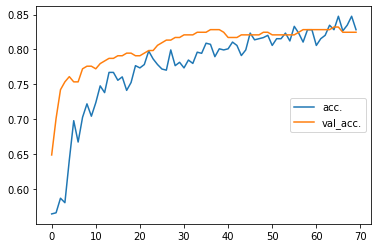

In [16]:
plt.plot(history.history["accuracy"],label="acc.")
plt.plot(history.history["val_accuracy"],label="val_acc.")
plt.legend(loc="center right")

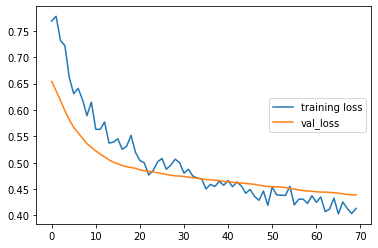

In [17]:
plt.plot(history.history["loss"],label="training loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend(loc="center right")

### Making predictions of test set...

In [18]:
X_t=test_data.values
X_test=data_gen(X_t,test_data)
Y_test=pd.get_dummies(test_output['Survived']).values
print(X_test.shape,Y_test.shape)

(418, 55) (418, 2)


In [19]:
model.evaluate(X_test,Y_test)

418/418 [==============================] - 0s 93us/step


[0.5093466462701132, 0.7727272510528564]

#### So the model gives loss = 0.509 with accuracy of 77.272%.

In [20]:
z=np.round(model.predict(X_test))==Y_test

#### Printing wrong predictions...

In [21]:
s=0
for i in range(X_test.shape[0]):
    if z[i][0]==False:
        print(str(i),test_output['Survived'][i],X_t[i])
        s+=1

1 1 [893 3 'Wilkes, Mrs. James (Ellen Needs)' 'female' 47.0 1 0 '363272' 7.0
 nan 'S']
4 1 [896 3 'Hirvonen, Mrs. Alexander (Helga E Lindqvist)' 'female' 22.0 1 1
 '3101298' 12.2875 nan 'S']
5 1 [897 3 'Svensson, Mr. Johan Cervin' 'male' 14.0 0 0 '7538' 9.225 nan 'S']
6 0 [898 3 'Connolly, Miss. Kate' 'female' 30.0 0 0 '330972' 7.6292 nan 'Q']
7 1 [899 2 'Caldwell, Mr. Albert Francis' 'male' 26.0 1 1 '248738' 29.0 nan
 'S']
18 0 [910 3 'Ilmakangas, Miss. Ida Livija' 'female' 27.0 1 0 'STON/O2. 3101270'
 7.925 nan 'S']
23 1 [915 1 'Williams, Mr. Richard Norris II' 'male' 21.0 0 1 'PC 17597'
 61.3792 nan 'C']
32 1 [924 3 'Dean, Mrs. Bertram (Eva Georgetta Light)' 'female' 33.0 1 2
 'C.A. 2315' 20.575 nan 'S']
34 1 [926 1 'Mock, Mr. Philipp Edmund' 'male' 30.0 1 0 '13236' 57.75 'C78' 'C']
36 1 [928 3 'Roth, Miss. Sarah A' 'female' 28.0 0 0 '342712' 8.05 nan 'S']
38 1 [930 3 'Sap, Mr. Julius' 'male' 25.0 0 0 '345768' 9.5 nan 'S']
39 1 [931 3 'Hee, Mr. Ling' 'male' 28.0 0 0 '1601' 56.4958 n

In [22]:
print(s)                              #total number of wrong predictions.

95
